<a href="https://colab.research.google.com/github/b-mi/colab/blob/main/cvicenie3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import random

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda( lambda x: x.double())
])

#trainset = datasets.CIFAR10("./datasets/", download=True, train=True, transform = transform)
#testset = datasets.CIFAR10("./datasets/", download=True, train=False, transform = transform)
#img_size = 32
#out_size = 10

#trainset = datasets.MNIST("./datasets/", download=True, train=True, transform = transform)
#testset = datasets.MNIST("./datasets/", download=True, train=False, transform = transform)
#img_size = 28
#out_size = 10

trainset = datasets.EMNIST("./datasets/", download=True, train=True, transform = transform, split="balanced")
testset = datasets.EMNIST("./datasets/", download=True, train=False, transform = transform, split="balanced")
img_size = 28
out_size = 47

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
def show_images(images, labels, rows=6, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    for idx in range(0, rows * cols):
        ridx = idx // cols
        cidx = idx % cols
        
        ax = axes[ridx, cidx]
        ax.axis("off")
        
        #ax.imshow(transforms.ToPILImage()(images[idx].squeeze()))
        ax.imshow(images[idx].squeeze(), cmap="gray_r")
        ax.set_title("{}".format(labels[idx]), pad=0)
        
        #ax.set_title("{}".format(labels[idx]))
        #ax.set_title("{}".format(caps[3]))
    plt.show()
    return fig

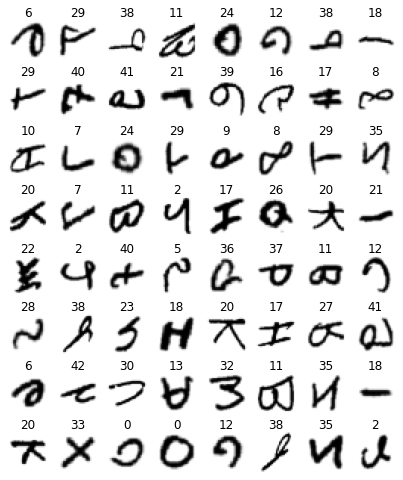

In [ ]:
# ukazka dat
fig = show_images(images, labels, rows=8, cols=8)

In [ ]:
def convert_to_vectors(labels):
    newla = []
    for idx in labels:
        la = np.zeros(out_size)
        la[idx] = 1.0
        newla.append(la)
    onearray = np.vstack(newla)
    tlabs = torch.from_numpy(onearray)
    return tlabs

In [ ]:
# variabilna NN s parametrickym optimalizatorom a aktivatorom, a poctami neuronov v hidden layeroch
class NNv1(nn.Module):
    def __init__(self, activator, hidden1_size, hidden2_size):
        super(NNv1, self).__init__()
 
        self.input_layer_weights = nn.Linear(img_size * img_size, hidden1_size)
        self.hidden_layer1_weights = nn.Linear(hidden1_size, hidden2_size)
        self.hidden_layer2_weights = nn.Linear(hidden2_size, out_size)
        
        self.act1 = activator()
        self.act2 = activator()
        self.act3 = nn.Softmax(dim=1)
        self.double()
        
    def forward(nn, x):
        x = nn.input_layer_weights(x)
        x = nn.act1(x)

        x = nn.hidden_layer1_weights(x)
        x = nn.act2(x)

        x = nn.hidden_layer2_weights(x)
        x = nn.act3(x)
        return x

In [ ]:
def train_model(model, opt, epochs=15):
    mse = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        _loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            opt.zero_grad()
            preds = model(images)
            labels = convert_to_vectors(labels)
            loss = mse(preds, labels)
            loss.backward()
            
            opt.step()
            _loss += loss.item()
        else:
            avg_loss = _loss / len(trainloader)
            losses.append(avg_loss)
            print("epoch {} - loss: {}".format(epoch, avg_loss))
    return model, losses

In [ ]:
# brute force pre prehaladavenie roznymi optimalizatormi, aktivatormi a velkostou siete
opts = [
    optim.Adam, 
    optim.AdamW, 
    optim.Adamax, 
]

acts = [
    nn.PReLU,
    nn.ReLU,
    nn.ReLU6,
    nn.SELU,
    nn.GELU,
    nn.SiLU
]

layers = [
    (128, 32),
    (256, 20),
    (512, 64),
    (256, 128)
]

# ak sa to ma spustit treba zmenit na True
doTrain = False
results = []

if doTrain:
    for opt in opts: # optimizery
        for act in acts: # aktivatory
            for layer in layers:
                hid1, hid2 = layer
                print("Optimizer: {}, Aktivator: {}, Hid1: {}, Hid2: {}".format(opt.__name__, act.__name__, hid1, hid2))
                model = NNv1(act, hid1, hid2)
                optobj = opt(model.parameters())
                model, losses = train_model(model, optobj, 10)
                print("Optimizer: {}, Aktivator: {}, Loss: {:2}".format(opt.__name__, act.__name__, losses[-1]))
                results.append((opt.__name__, act.__name__, losses[-1], hid1, hid2))


In [ ]:
sort_results = sorted( results, key=lambda tup: tup[2])
for r in sort_results:
    o, a, l, h1, h2 = r
    print("opt: {}\tact: {}\tloss: {}\thid1: {}\thid2: {}".format( o, a, l, h1, h2))

In [ ]:
# vybrate vysledky

#Optimizer: Adamax, Aktivator: PReLU, Hid1: 512, Hid2: 64
#Optimizer: Adamax, Aktivator: PReLU, Hid1: 256, Hid2: 128
#Optimizer: Adamax, Aktivator: SELU, Hid1: 512, Hid2: 64
best = [ 
    (optim.Adamax, nn.PReLU, 512, 128), 
    (optim.Adam, nn.ReLU, 256, 64),
    (optim.AdamW, nn.GELU, 512, 32)

]

In [ ]:
# train vybratych vysledkov na 30 epochach
results = []
for bv in best:
    opt, act, h1, h2 = bv
    model = NNv1(act, h1, h2)
    optobj = opt(model.parameters())
    model, losses = train_model(model, optobj, 30)
    print("Optimizer: {}, Aktivator: {}, H1: {}, H2: {}, Loss: {:4f}".format(opt.__name__, act.__name__, h1, h2, losses[-1]))
    results.append((opt.__name__, act.__name__, h1, h2, losses, model))

epoch 0 - loss: 0.00960922779970289
epoch 1 - loss: 0.006303596854094346
epoch 2 - loss: 0.005403411562923795
epoch 3 - loss: 0.004905895992731136
epoch 4 - loss: 0.004555739176871955
epoch 5 - loss: 0.004306748699975551
epoch 6 - loss: 0.004088823086884641
epoch 7 - loss: 0.003931120746507767
epoch 8 - loss: 0.003786565796267729
epoch 9 - loss: 0.003643427731918682
epoch 10 - loss: 0.0035220501298566112
epoch 11 - loss: 0.00340544936934411
epoch 12 - loss: 0.003303366994529118
epoch 13 - loss: 0.003204824450608846
epoch 14 - loss: 0.0031155981426698788
epoch 15 - loss: 0.0030412543116371685
epoch 16 - loss: 0.002970928240694467
epoch 17 - loss: 0.002881042513290962
epoch 18 - loss: 0.0028111524740105443
epoch 19 - loss: 0.002767143051475703
epoch 20 - loss: 0.0026781705354870723
epoch 21 - loss: 0.0026394141506646666
epoch 22 - loss: 0.00257553756494727
epoch 23 - loss: 0.0025090552675082595
epoch 24 - loss: 0.002462470641496435
epoch 25 - loss: 0.002403000218570135
epoch 26 - loss: 0

In [ ]:
def plot_loss(resls):
    fig = plt.figure(figsize=(18,16))
    clrs = ["g", "r", "b", "y"]
    clridx = 0
    
    for res in resls:
        opt, act, h1, h2, losses, model = res
        line, = plt.plot(losses, color=clrs[clridx])
        line.set_label("{}.{}.{}.{}".format(opt, act, h1, h2))
        clridx += 1
        
    plt.legend()
    
    #plt.ylim(bottom=0.02, top = 0.08)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    #plt.show()
    return fig

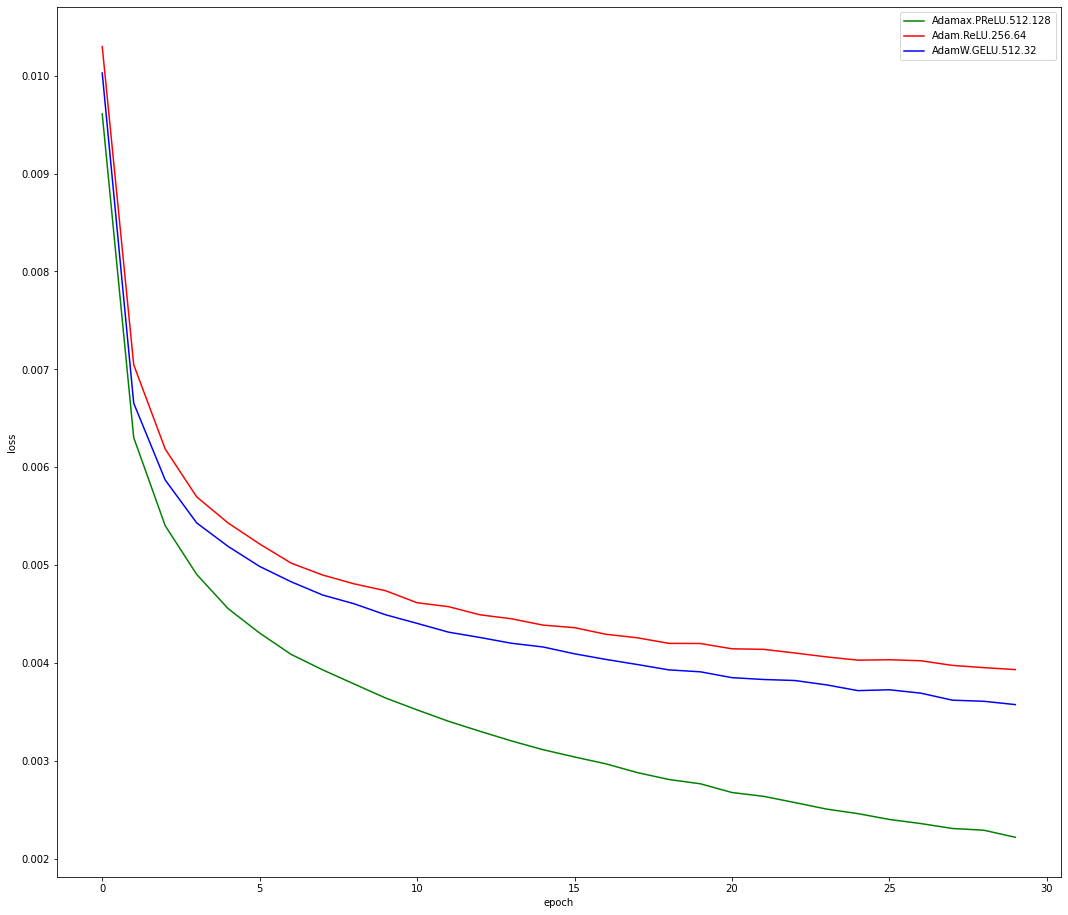

In [ ]:

fig = plot_loss(results)


In [ ]:
def validate_model(model, testset):
    correct_count, all_count = 0,0
    wrong_predictions = []
    for image, label in testset:
        with torch.no_grad():
            pred = model(image.view(1,img_size * img_size))[0]
        pred_label = pred.argmax()
        if pred_label == label:
            correct_count += 1
        else:
            wrong_predictions.append((image, label, pred_label))
        all_count += 1
    return all_count, correct_count/all_count, wrong_predictions

In [ ]:
#validacia na testovacich datach
for res in results:
    opt, act, h1, h2, losses, model = res
    total, accuracy, wrong_preds = validate_model(model, testset)
    print("{}.{}.{}.{}".format(opt, act, h1, h2))
    print("testovanych: {}".format(total))
    print("presnost: {:2%}\n".format(accuracy))

Adamax.PReLU.512.128
testovanych: 18800
presnost: 84.904255%

Adam.ReLU.256.64
testovanych: 18800
presnost: 82.484043%

AdamW.GELU.512.32
testovanych: 18800
presnost: 83.489362%



In [ ]:
def show_wrong_preds(wrong_preds, rows = 5, cols = 5):
    preds = random.sample(wrong_preds, rows * cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    plt.subplots_adjust(bottom=0.0, right=1.0, left=0.1, top=1.0)
    for idx, (img, label, pred_label) in enumerate(preds):
        ridx = idx // cols
        cidx = idx % cols
        
        ax = axes[ridx, cidx]
        ax.axis("off")
        ax.imshow(img.squeeze(), cmap="gray_r")
        ax.set_title("{}!={}".format(label, pred_label))
    plt.show()
    return fig

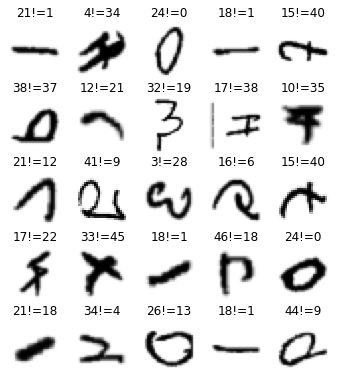

In [ ]:
# ukazky nespravnych predpovedi
fig = show_wrong_preds(wrong_preds)

In [ ]:
def show_prediction_probability(img, predictions, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img.squeeze().view(img_size, img_size), cmap="gray_r")
    ax2.bar(np.arange(0, out_size), predictions.detach().numpy())
    ax2.set_title(title)
    plt.show()
    return fig

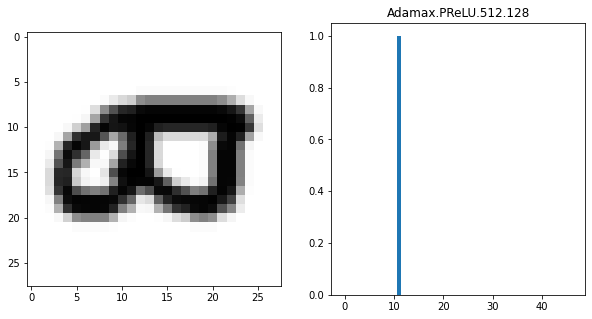

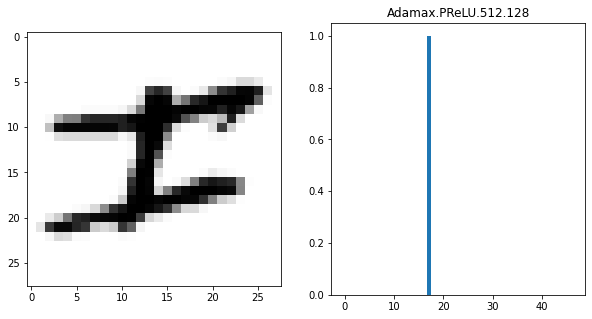

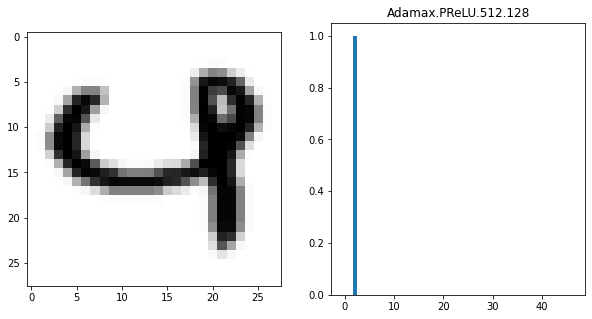

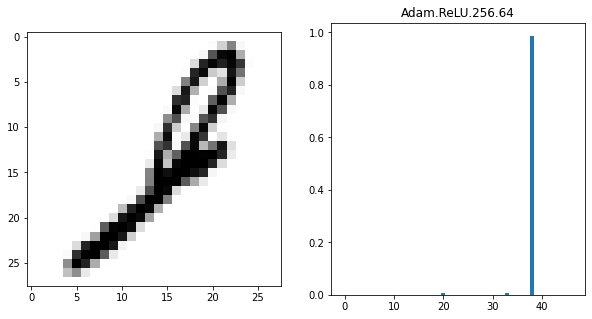

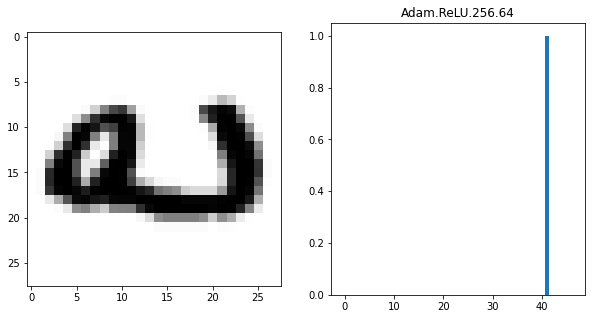

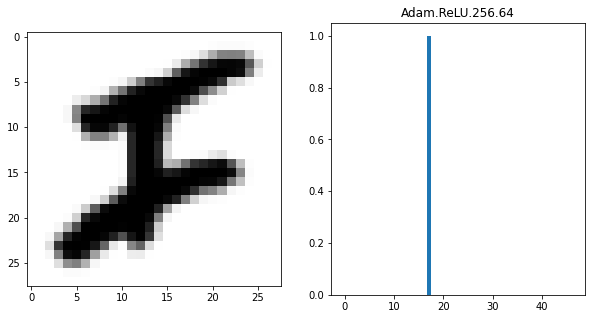

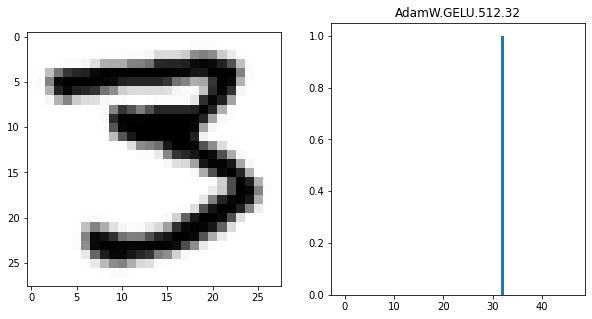

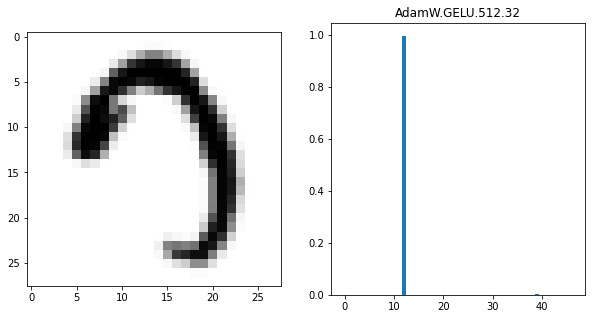

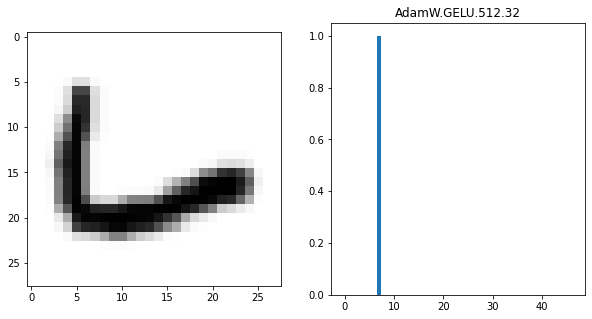

In [ ]:
#3x3 ukazok istoty prepovedania NN
for res in results:
  opt, act, h1, h2, losses, model = res
  for idx in random.sample(range(0, 63), 3 ):
    img = images[idx]
    pred = model(img.view(1, -1))
    fig = show_prediction_probability(img, pred.squeeze(), "{}.{}.{}.{}".format(opt, act, h1, h2))


In [ ]:
def show_layer(neurons, title):
    #count = len(neurons)
    count = 64
    cols = 8
    rows = count // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(title)
    for idx in range(0,count):
        subplot_row = idx // cols
        subplot_col = idx % cols
        ax = axes[subplot_row][subplot_col]
        ax.matshow(neurons[idx].reshape(img_size,img_size).detach(), cmap="gray")
        ax.axis("off")
    return fig

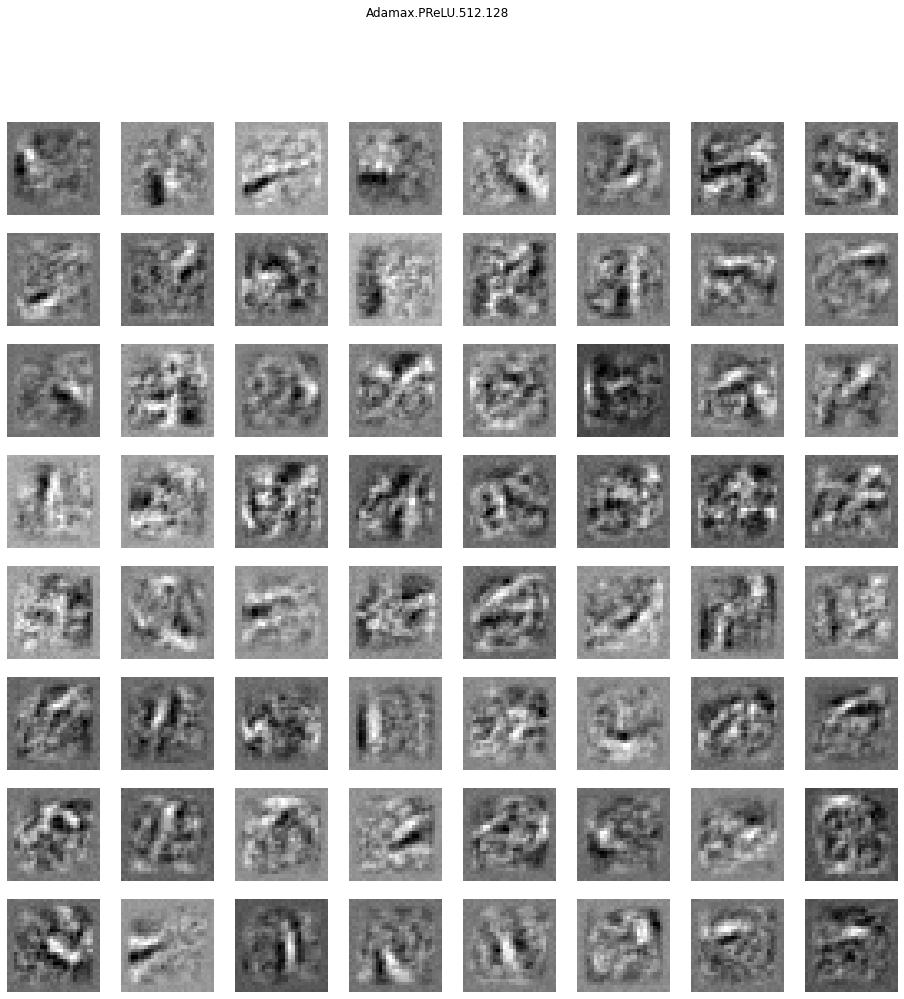

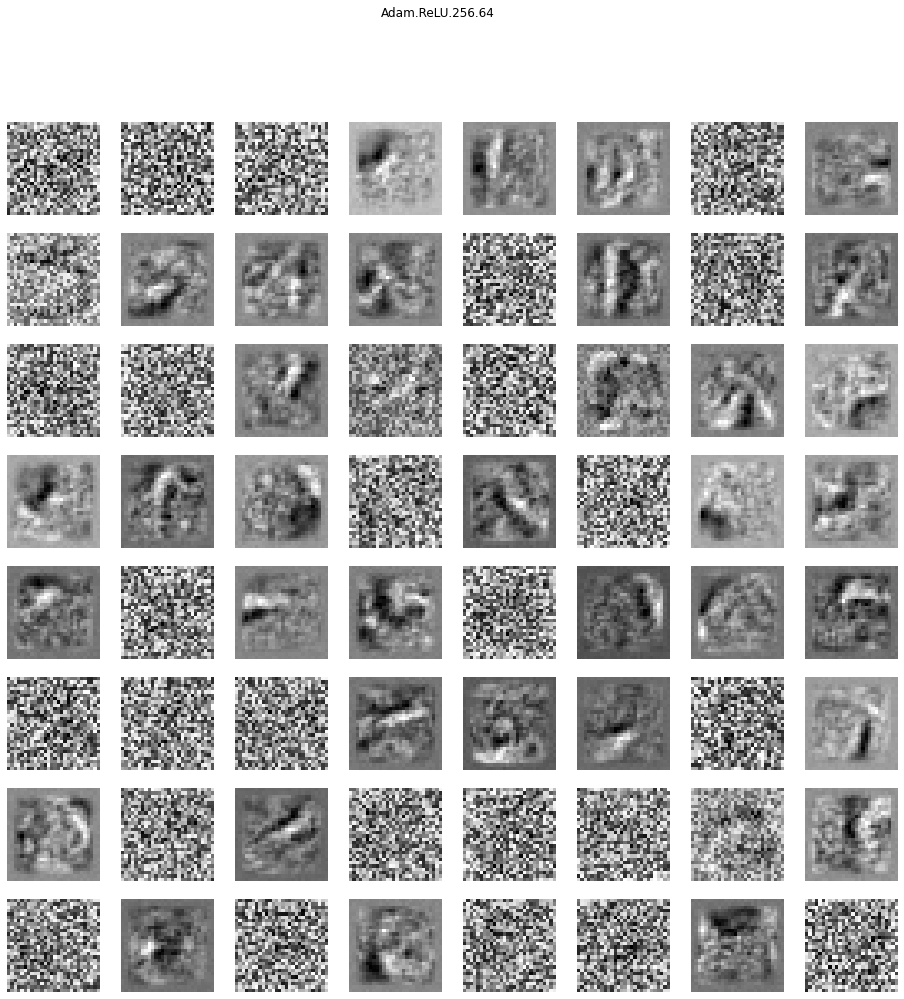

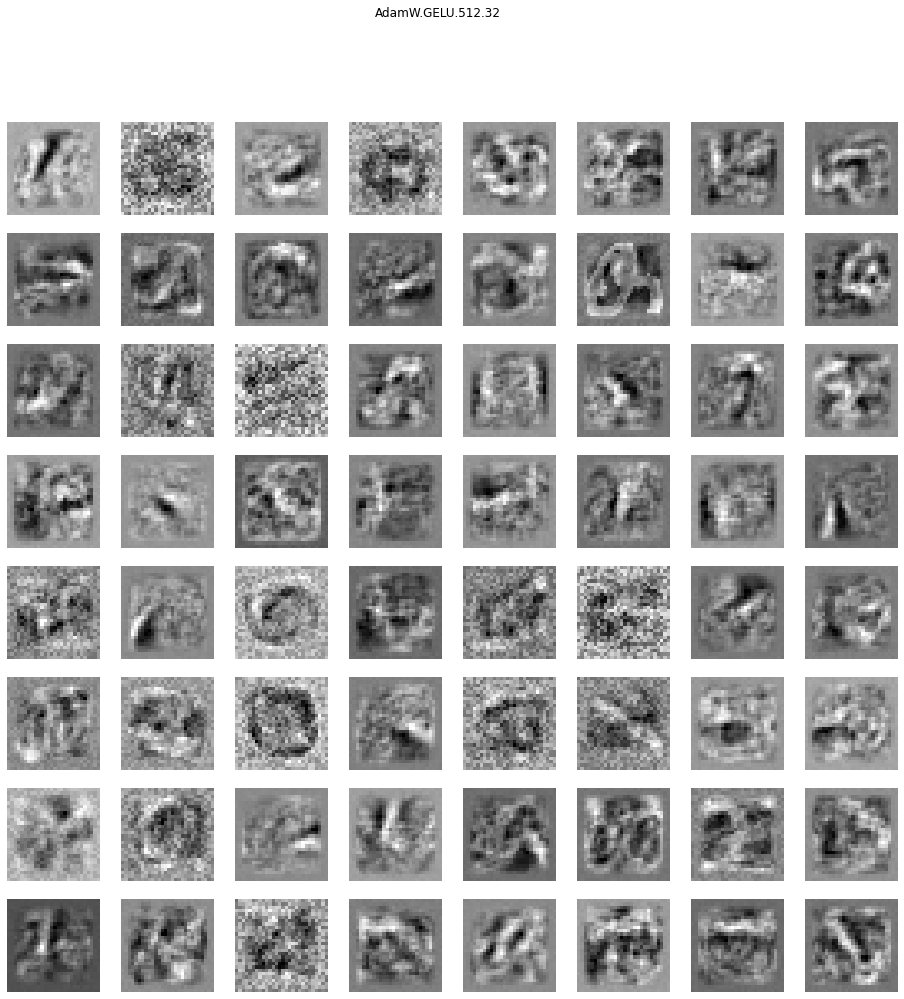

In [ ]:
#ukazka ako si to nn organizuje
for res in results:
  opt, act, h1, h2, losses, model = res
  title = "{}.{}.{}.{}".format(opt, act, h1, h2)
  params = list(model.parameters())
  #print(params[0].size())
  #print(len(params[1]))
  fig = show_layer(params[0], title)